In [11]:
import praw
import os
import re
import threading
import time
import random
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# Cleaning the Data

In [ ]:
#read 
try:
    df = pd.read_pickle("Scrubdata [jul 12 16].pkl")
except: 
    print("Could not read dataframe")
display(df)

In [ ]:
# Convert Weapon to Weapon ID
# Read weapons from txt
def read_weapons(filePath):
    with open(filePath, "r",) as inf:
        lines = inf.readlines()
        wepIDdict = {"Barehand":0}
        wepElemdict = {0:"-"}
        for line in lines:
            pat = re.search(r"\(ID: (\d+)\) (.+) \((\w+|-)\)", line)
            if (pat == None):
                print("did not find weapon in:\n",line)
            else:
                wepIDdict[pat.group(2)] = int(pat.group(1))
                wepElemdict[int(pat.group(1))] = pat.group(3)
        return (wepIDdict, wepElemdict)
    return None


In [ ]:
# # Data Clean up
df['Date']=df['Time'].apply((lambda x: time.asctime(time.gmtime(x))))
df.rename(columns = {'Weak/Noot/Resist':'W/N/R', 'Lucky Crit':'L-Crit', 'Extra Damage':'Ext-Damage', 'Attacker Level':'Level'}, inplace = True)
df.sort_values(by="Time", ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
# df.drop(columns=["Comment ID"], inplace=True)
# df.drop(columns=["Parent ID"], inplace=True)
df["L-Crit"] = False
df["Weapon"] = df["Weapon"].apply(lambda x: x if(x != "Singing &amp; Dancing Sword") else "Singing & Dancing Sword")
iddict, elemdict = read_weapons("weapons.txt")
df["W-ID"] = df["Weapon"].apply(lambda x: iddict.get(x, "-"))
df["W-Element"] = df["W-ID"].apply(lambda x: elemdict.get(x, "-"))
df = df[['Date', 'Weapon', "W-ID","W-Element", 'Damage', 'XP', 'Gold', 'Ext-Damage', 'W/N/R', 'Crit', 'L-Crit', 'Kill', 'Level', 'Hp left', "Attacker Race", "Time to reply", "Time", 'Comment ID', 'Post ID', 'Parent ID']]
#df = df[['Date', 'Weapon', "W-ID","W-Element", 'Damage', 'XP', 'Gold', 'Ext-Damage', 'W/N/R', 'Crit', 'L-Crit', 'Kill', 'Level', 'Hp left', 'Time', 'Post ID']]

display(df)

In [ ]:
# Cleaning up flairs:
#Mark mods:
probablyMods = ["Bot Daddy #3", "Friendly Neighbourhood Mod", "Rat Queen (Orc)", "Bot Creator/Manager (Orc)", "Inactive, message the other mods", "Bot Daddy #3 (Elf)", "beany boi","Posting overused memes is my speciality", "Bot Creator/Manager", "potatoe ★", "potatoe", "haha im xndo", "Posting overused memes is my specialty", "Ugh, go on then ", "Pick one: 'WAHHH' or 'Meow'", "I have become what I swore to destroy"]
for mod in probablyMods:
	df.loc[df["Attacker Race"]==mod,"Attacker Race"] = "Mod/Admin"

#Clean School flairs:
flairs = df["Attacker Race"].unique()
schoolBook = {}
for flair in flairs:
	if (flair == None): continue
	if(re.search(r"(Jock|Nerd|Goth|Prep)", flair) != None):
		fl = flair
		flair = flair.replace("Prep", "Elf")
		flair = flair.replace("Goth", "Dwarf")
		flair = flair.replace("Nerd", "Halfling")
		flair = flair.replace("Jock", "Orc")
		schoolBook[fl] = flair
df["Attacker Race"] = df["Attacker Race"].apply(lambda x: schoolBook.get(x,x))

# Remove Stars:
flairs = df["Attacker Race"].unique()
nopre = {}
for flair in flairs:
	if (flair == None): continue
	if(flair.find("Elf") != -1):
		nopre[flair] = "Elf"
		continue
	if(flair.find("Dwarf") != -1):
		nopre[flair] = "Dwarf"
		continue
	if(flair.find("Halfling") != -1):
		nopre[flair] = "Halfling"
		continue
	if(flair.find("Orc") != -1):
		nopre[flair] = "Orc"
		continue
df["Attacker Race"] = df["Attacker Race"].apply(lambda x: nopre.get(x,x))

# Clear out oddities (some comments which had no race specified in flair)
idkh = {"chembud8253":"Elf", "andysbelle":"Elf", "Race ":"Halfling", "sser_":"Elf", "None":"[deleted]", "icommentedonyourpost":"Orc", "Iamcool999999":"Dwarf", "ImaginaryNeon":"Dwarf", "hiima0440":"Elf", "RSZephoria":"Dwarf"}
df["Attacker Race"] = df["Attacker Race"].apply(lambda x: idkh.get(x,x))

### Clean out none of the above 
# allowedFlairs = ['Orc', 'Dwarf', 'Elf', 'Halfling', 'Mod/Admin', '[deleted]']
# flairs = df["Attacker Race"].unique()
# for flair in flairs:
# 	if (flair == None): continue	
# 	if (flair not in allowedFlairs):
# 		df.loc[df["Attacker Race"]==flair,"Attacker Race"] = None
# df["Attacker Race"].unique()

print(df["Attacker Race"].unique())

In [49]:
# Find Comment
#display(df.loc[df["Weapon"] == "Definitely not Admin abuse", :])
import praw
reddit = praw.Reddit("WhatIsBaitBot", user_agent = "<Scrubbot1.0>")
print("reddit.com"+reddit.comment("g9xdxjj").permalink)

reddit.com/r/kickopenthedoor/comments/jhc6gd/you_cannot_outrun_death_health544/g9xdxjj/


In [ ]:
# Add it to old data
try:
    olddf = pd.read_pickle("Cleaned Data upto jul 5.pkl")
except: 
    print("Could not read dataframe")
newdf = pd.concat([df,olddf], ignore_index=True)
newdf.drop_duplicates(subset = ['Comment ID'])
newdf.sort_values(by="Time", ascending=False, inplace=True)
newdf['Date']=newdf['Time'].apply((lambda x: time.asctime(time.gmtime(x))))
newdf.to_pickle("Cleaned Data upto jul 12.pkl")

# Analyzing the Data

In [18]:
#read 
try:
    df = pd.read_pickle("Cleaned Data upto jul 12.pkl")
except:
    print("Could not read dataframe")
display(df.tail())

,Date,Weapon,W-ID,W-Element,Damage,XP,Gold,Ext-Damage,W/N/R,Crit,...,Kill,Level,Hp left,Attacker Race,Time to reply,Time,Comment ID,Post ID,Parent ID,Killed by
0,Tue Jul 12 13:21:43 2022,Barehand,0,-,13,8,15,0,N,True,...,False,15,3312,Elf,56.0,1657632103,ifuqot3,vx3ar2,ifuqkgw,-
1,Tue Jul 12 13:21:31 2022,Human Shield,22,Curse,20,11,44,15,W,False,...,False,43,3325,Elf,52.0,1657632091,ifuqnuz,vx3ar2,ifuqjtu,-
2,Tue Jul 12 13:21:15 2022,Human Shield,22,Curse,17,10,43,15,W,False,...,False,43,1885,Elf,39.0,1657632075,ifuqmm8,vx39if,ifuqjkw,-
3,Tue Jul 12 13:21:02 2022,Barehand,0,-,6,4,164,0,N,False,...,False,100,35283,Halfling,27.0,1657632062,ifuqlk8,vv8sed,ifuqji4,-
4,Tue Jul 12 13:19:32 2022,Barehand,0,-,5,4,188,0,N,False,...,False,112,35289,Elf,31.0,1657631972,ifuqekt,vv8sed,ifuqc3g,-


### Race Activity over time:

#### Attacks over the history of KOTD

In [ ]:
subdf = df.iloc[:,:]

subdf['cdate'] = pd.to_datetime(subdf['Time'], unit='s')

f, axes = plt.subplots(5,figsize=(20,20))
races = ["Elves","Dwarves","Halflings","Orcs","Everyone"]
for i, ax in enumerate(axes):
	ax.set_ylim(0,2000)
	ax.set_yticks(np.arange(0, 2000+1, 250))
	ax.set_xlabel(races[i],fontsize = 12)
	ax.set_ylabel("Attack Count",fontsize = 12)
axes[4].set_ylim(0,5000)
ax.set_yticks(np.arange(0, 5000+1, 500))

f.patch.set_facecolor('white')

sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Elf"),:], x="cdate", color="purple", binwidth=1, ax=axes[0])
sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Dwarf"),:], x="cdate", color="blue", binwidth=1, ax=axes[1])
sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Halfling"),:], x="cdate", color="orange", binwidth=1, ax=axes[2])
sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Orc"),:], x="cdate", color="green", binwidth=1, ax=axes[3])
sns.histplot(data=subdf, x="cdate", color="grey", binwidth=1, ax=axes[4])
plt.savefig('race activity.png', dpi=100)
plt.show()


#### Kills over the history of KOTD

In [ ]:
subdf = df.loc[df["Kill"]==True,:]

subdf['cdate'] = pd.to_datetime(subdf['Time'], unit='s')

f, axes = plt.subplots(5,figsize=(20,20))
races = ["Elves","Dwarves","Halflings","Orcs","Everyone"]
for i, ax in enumerate(axes):
	ax.set_ylim(0,25)
	ax.set_yticks(np.arange(0, 25+1, 5))
	ax.set_xlabel(races[i],fontsize = 12)
	ax.set_ylabel("Kill Count",fontsize = 12)
axes[4].set_ylim(0,45)
ax.set_yticks(np.arange(0, 46, 5))

f.patch.set_facecolor('white')

sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Elf"),:], x="cdate", color="purple", binwidth=2, ax=axes[0])
sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Dwarf"),:], x="cdate", color="blue", binwidth=2, ax=axes[1])
sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Halfling"),:], x="cdate", color="orange", binwidth=2, ax=axes[2])
sns.histplot(data=subdf.loc[(subdf["Attacker Race"]=="Orc"),:], x="cdate", color="green", binwidth=2, ax=axes[3])
sns.histplot(data=subdf, x="cdate", color="grey", binwidth=2, ax=axes[4])
plt.savefig('race kills.png', dpi=100)
plt.show()


#### Damage over the History of KOTD

In [21]:
def damage_per_period(df, trange = 24*60*60, maxtime = df["Time"].max(), mintime=df["Time"].min()):
	damrace = []
	df = df.loc[(df["Time"]<=maxtime)&(df["Time"]>mintime),["Attacker Race", "Time", "Damage"]]
	for interval in range(maxtime, mintime, -trange):
		for race in ["Elf","Dwarf","Halfling","Orc"]:
			idf = df.loc[(df["Time"]<=interval)&(df["Time"]>interval-trange)&(df["Attacker Race"]==race),["Time", "Damage"]]
			damrace.append([interval-trange, race, idf["Damage"].sum()])

	subdf = pd.DataFrame(damrace, columns=["Time", "Attacker Race", "Damage"])
	subdf['cdate'] = pd.to_datetime(subdf["Time"], unit='s')
	return subdf

In [ ]:
subdf = damage_per_period(df, 24*60*60*7)
f, axes = plt.subplots(figsize=(20,10))
axes.set_xlabel("Date",fontsize = 12)
axes.set_ylabel("Damage delt in one week",fontsize = 12)
axes.set_ylim(0,150000)
axes.set_yticks(np.arange(0, 150000+1, 10000))
f.patch.set_facecolor('white')
plt.grid()
sns.lineplot(data=subdf, x="cdate", y="Damage", hue="Attacker Race", palette=["purple","blue","orange","green"], ax=axes)
# plt.savefig('race damage over life time.png', dpi=100)
plt.show()

#### Race activity over the day

In [20]:
subdf = damage_per_period(df, 60*60, mintime=df["Time"].max()-7*24*60*60)
li = []
for i,race in enumerate(["Elf","Dwarf","Halfling","Orc"]):
	for j in range(0,24):
		idf = subdf.loc[subdf["Attacker Race"]==race].iloc[j::24,:].reset_index()
		li.append([race, idf["Damage"].mean(), idf.iloc[0,4]])

mddf = pd.DataFrame(li, columns=["Attacker Race", "Damage", "cdate"])


NameError: name 'damage_per_period' is not defined

In [ ]:
from matplotlib.ticker import MultipleLocator

f, axes = plt.subplots(figsize=(16,8))
axes.set_xlabel("Date",fontsize = 12)
axes.set_ylabel("Damage/hour",fontsize = 12)
axes.set_ylim(0,1000)
axes.set_yticks(np.arange(0, 1000+1, 100))
f.patch.set_facecolor('white')
axes.xaxis.set_minor_locator(locator=MultipleLocator(1/24))
plt.grid()
sns.lineplot(data=mddf, x="cdate", y="Damage", hue="Attacker Race", palette={"Elf":"purple","Dwarf":"blue","Halfling":"orange","Orc":"green"}, ax=axes)
plt.savefig('race damage over day GMT.png', dpi=100)
plt.show()

#### Race activity over the week

In [39]:
subdf = damage_per_period(df, 3*60*60, mintime=df["Time"].max()-28*24*60*60)
print("done dpp")
li = []
for i,race in enumerate(["Elf","Dwarf","Halfling","Orc"]):
	for j in range(0,8*7):
		idf = subdf.loc[subdf["Attacker Race"]==race].iloc[j::8*7,:].reset_index()
		li.append([race, idf["Damage"].mean(), idf.iloc[0,4]])

mddf = pd.DataFrame(li, columns=["Attacker Race", "Damage", "cdate"])
mddf

done dpp


,Attacker Race,Damage,cdate
0,Elf,1933.25,2022-07-12 10:21:43
1,Elf,1303.75,2022-07-12 07:21:43
2,Elf,1123.25,2022-07-12 04:21:43
3,Elf,1232.00,2022-07-12 01:21:43
4,Elf,1740.75,2022-07-11 22:21:43
...,...,...,...
219,Orc,911.75,2022-07-06 01:21:43
220,Orc,1018.00,2022-07-05 22:21:43
221,Orc,937.25,2022-07-05 19:21:43
222,Orc,1096.50,2022-07-05 16:21:43


<ipython-input-41-7baa3b12692c>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels=["Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "Monday", "Tuesday"]) #, rotation=45, ha='right'


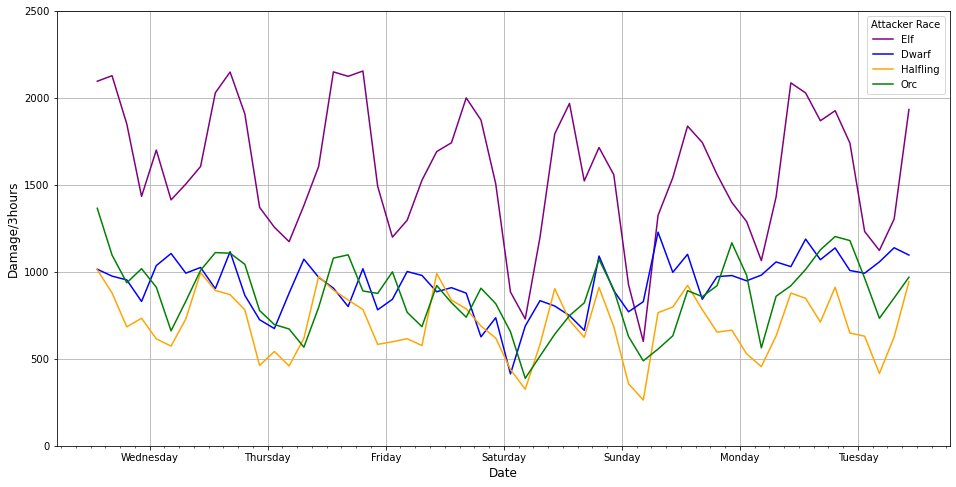

In [41]:
from matplotlib.ticker import MultipleLocator

f, axes = plt.subplots(figsize=(16,8))
axes.set_xlabel("Date",fontsize = 12)
axes.set_ylabel("Damage/3hours",fontsize = 12)
axes.set_ylim(0,2500)
axes.set_yticks(np.arange(0, 2500+1, 500))
f.patch.set_facecolor('white')
axes.xaxis.set_minor_locator(locator=MultipleLocator(3/24))
plt.grid()
sns.lineplot(data=mddf, x="cdate", y="Damage", hue="Attacker Race", palette={"Elf":"purple","Dwarf":"blue","Halfling":"orange","Orc":"green"}, ax=axes)
axes.set_xticklabels(labels=["Wednesday", "Thursday", "Friday", "Saturday", "Sunday", "Monday", "Tuesday"]) #, rotation=45, ha='right'

plt.savefig('race damage over week GMT.png', dpi=100)
plt.show()

### Plotting damage to XP

In [ ]:
select = (df["Time"] >= 1612180800) & (df["Post ID"]!="t3_np9d83") & (df["Weapon"] != "Definitely not Admin abuse")
xdf = df.loc[select,:]
# xdf = df.sort_values(by="XP")
# xdf

In [ ]:
xpdamagelist = []
for i in xdf["Damage"].unique():
	idf = xdf.loc[xdf["Damage"]==i,:]
	xpdamagelist.append([i, idf["XP"].mean()])

xpdamagedf = pd.DataFrame(xpdamagelist, columns=["damage","ave xp"])

plt.figure()
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, xdf["Damage"].max()+1, 5))
ax.set_yticks(np.arange(0, xdf["XP"].max()+1, 2))
plt.grid()
fig.patch.set_facecolor('white')
plt.xlabel("Damage", fontsize = 14)
plt.ylabel("XP", fontsize = 14)

sns.lineplot(x='damage', y='ave xp', color='red', data=xpdamagedf) 

plt.savefig('xp-damage.png', dpi=100)
plt.show()
xdf = None

### Plot Level to Gold


In [ ]:
select = (df["Time"] >= 1612180800) & (df["L-Crit"] == False) & (df["Post ID"]!="t3_np9d83")
gdf = df.loc[select,:]
# gdf = gdf.sort_values(by="Gold")
# gdf


In [ ]:
# I used a for loop here because it is much faster than sns estimators
# goldLevellist = []
# for i in range(2, 128):
# 	idf = gdf.loc[gdf["Level"]==i,:]
# 	goldLevellist.append([i, idf["Gold"].mean(), idf["Gold"].min(), idf["Gold"].max()])

# goldLeveldf = pd.DataFrame(goldLevellist, columns=["level","ave gold", "min gold", "max gold"])

fig = plt.figure(figsize=(6,7))
ax = fig.gca()
ax.set_xticks(np.arange(0, 131, 10))
ax.set_yticks(np.arange(0, 226, 25))
plt.grid()
fig.patch.set_facecolor('white')
plt.xlabel("Level", fontsize = 14)
plt.ylabel("Gold", fontsize = 14)

sns.lineplot(x='level', y='ave gold', color='lime', data=goldLeveldf) 
sns.lineplot(x='level', y='max gold', color='yellow', data=goldLeveldf) 
sns.lineplot(x='level', y='min gold', color='yellow', data=goldLeveldf) 

plt.savefig('gold-level.png', dpi=100)
plt.show()
# gdf = None

### Finding the attack with the most damage


In [ ]:
ddf = df.sort_values(by="Damage", ascending=False, inplace=False)

#ddf = ddf[ddf["Damage"] - ddf["Extra Damage"] < 30]
#ddf = ddf[ddf["Weapon"] == "Barehand"]
#ddf = ddf[ddf["Time"] >= 1612180800]   # Starting Feb 1st 2021
#ddf = ddf[ddf["Post ID"]!="t3_np9d83"] # NO MEGA BOSS
select = (ddf["Time"] >= 1612180800) & (ddf["L-Crit"] == False) & (ddf["Post ID"]!="t3_np9d83")
sdf = ddf.loc[select,:]
#display(sdf.head())
#display(ddf.loc[ddf["Damage"] == , :])
#print(sorted(list(df["Damage"].unique())))
# lucky crits between 17 march and 19 march; 1647475200 - 1647734400

### Weapon Stats:


In [ ]:
def ds_range(ds):
    mx = ds.max()
    mn = ds.min()
    return F"[{mn}, {mx}]"

select = (df["Time"] >= 1612180800) & (df["L-Crit"] == False) & (df["Post ID"]!="t3_np9d83")
sdf = df.loc[select,:]

wepIds = df["W-ID"].unique().tolist()
wepIds.remove("-")
wepIds = sorted(wepIds)
statlist = []
for effect in ['W', 'N', 'R']:
    for wepId in wepIds:
        stat = [wepId, effect]
        wselect = (sdf["W-ID"] == wepId) & (sdf["W/N/R"] == effect)
        wsdf = sdf.loc[wselect,:]               # df of all attacks using the weapon
        #if(len(wsdf)==0): break
        csdf = wsdf.loc[(wsdf["Crit"]==True),:] # df of all critical attacks using the weapon
        ssdf = wsdf.loc[(wsdf["Crit"]==False),:]# df of all non-critical attacks using the weapon

        stat.append(wsdf["Damage"].mean())      # mean damage
        stat.append(ssdf["Damage"].mean())      # mean non-critical damage
        stat.append(csdf["Damage"].mean())      # mean critical damage

        stat.append(ds_range(wsdf["Damage"]))   # damage range
        stat.append(ds_range(ssdf["Damage"]))   # non-criticl damage range
        stat.append(ds_range(csdf["Damage"]))   # critical damage range

        stat.append(len(wsdf))                  # sample size
        stat.append(len(csdf))                  # sample size of crit
        #stat.append(len(csdf)/len(wsdf) if (len(wsdf)!=0) else 0)        # crit rate
        
        statlist.append(stat)

statframe = pd.DataFrame(statlist, columns=["weapon", "effect", "ave damage", "w/o crits", "only crit", "range", "non-crit range", "crit range", "sample size", "of which crits"])
display(statframe)

statsframe = statframe[statframe["sample size"] != 0]
statsframe.to_csv(F"Weapon stats of jul 5 data.csv", index=False)
statsframe = statframe[statframe["sample size"] >= 5]
statsframe.to_csv(F"Weapon stats of jul 5 data - 5 or more samples.csv", index=False)

# Scrubbing:

In [1]:
import os
import re
import threading
import time
import numpy as np
import pandas as pd
import requests
import configparser

In [ ]:
# Defining scrub functions:    
def scrub_comment_body(body):
    # Is attack?
    hp = re.search(r"The boss has \*\*(-?\d+)\*\*", body)
    if(hp != None):
        # Determine Weapon and extra damage
        wepPat = re.search(r"You used the item '(.+)' and did (\d+)", body)
        if(wepPat == None):
            wep = "Barehand"
            extDmg = 0
        else:
            wep = wepPat.group(1)
            extDmg = int(wepPat.group(2))
        # Determine Damage XP and Gold
        stat = re.search(r"\| (\d+).* \| (\d+).*\| (\d+) \|", body)
        # Determine W/N/R
        statString = stat.group(0)
        affect = "N"
        if (re.search(r"\*\*\(WEAK!\)\*\*", statString) != None): affect = "W"
        elif (re.search(r"\*\*\(RESIST!\)\*\*", statString) != None): affect = "R"
        # Determine Crit
        crit = (re.search(r"\*\*\(CRIT!\)\*\*", statString) != None)
        # Determine Kill
        kill = (re.search(r"\*\*\(KILL!\)\*\*", statString) != None)
        # Determine Level
        lvl = int(re.search(r"level (\d+)", body).group(1))
        
        return [wep, int(stat.group(1)), int(stat.group(2)), int(stat.group(3)), extDmg, affect, crit, kill, lvl, int(hp.group(1))]
    else:
        return None

def get_author_comments(**kwargs):
    r = requests.get("https://api.pushshift.io/reddit/comment/search/",params=kwargs)
    data = r.json()
    return data['data']


In [2]:
# Create / Read dataframe
try:
    # incase an exception happens continue from last save point
    df = pd.read_pickle("Cleaned Data upto jul 12.pkl") # WRITE IN THE NAME OF THE FILE
except: 
    print("Making new Dataframe")
    df = pd.DataFrame(columns=['Time', 'Weapon', 'Damage', 'XP', 'Gold', 'Extra Damage', 'Weak/Noot/Resist', 'Crit', 'Kill', 'Attacker Level', 'Hp left', 'Attacker Race', 'Time to reply', 'Comment ID', 'Parent ID', 'Post ID'])

df["Killed by"] = "-"
# Define Constants:
REQUESTSIZE = 100
INIFILEPATH = 'praw.ini' # ini file with the auth info
AFTER = 0 # the time in seconds since epoch to stop search at
ROWINCREMENTS = 1000 # Rough number of rows processed between saves
SAVENAME = lambda row: "killer data ["+time.ctime()[4:13]+"]" # A lambda function returning the name of the temp/final save files (.pkl will be added automatically)

### Reading comments from pushshift.io

In [ ]:
# Create Control thread 
quit = False
def control():
    global quit
    while not quit:
        i = input()
        if (i == "q"):
            quit = True
        elif(i == "s"):
            os.abort()

thread = threading.Thread(target=control)
thread.daemon = True
thread.start()

# Start reading
if(len(df) == 0):
    before = None
else:
    before = df['Time'].min()

rubs = []
tstart = time.perf_counter()
while not quit:
    comments = get_author_comments(author="KickOpenTheDoorBot",size=REQUESTSIZE,before=before,sort='desc',sort_type='created_utc')
    if not comments: break #check if we reached the end

    for comment in comments:
        before = comment['created_utc']
        if (before <= AFTER):
            quit = True
            break
        try:
            textScrb = scrub_comment_body(comment["body"])
        except Exception as e:
            print(e)
            print(comment["body"])
            print(comment["id"])
            textScrb = None
        if(textScrb!=None):
            #Determine non-attack attributes
            t = comment["created_utc"]
            postid = comment["link_id"]
            comid = comment["id"]
            parid = comment["parent_id"]
            attRace = None
            tdif = None
            rubs.append([t]+textScrb+[attRace, tdif, comid, parid, postid])
    if(len(rubs) > ROWINCREMENTS):
        print(F"Processed {len(rubs)} new Entries in {time.perf_counter() - tstart} seconds")
        df = pd.concat([df, pd.DataFrame(rubs, columns=['Time', 'Weapon', 'Damage', 'XP', 'Gold', 'Extra Damage', 'Weak/Noot/Resist', 'Crit', 'Kill', 'Attacker Level', 'Hp left', 'Attacker Race', 'Time to reply', 'Comment ID', 'Parent ID', 'Post ID'])], ignore_index=True)
        print(F"New size: {len(df)}")
        print(F"Saving as {SAVENAME(len(df))}.pkl")
        df.to_pickle(F"{SAVENAME(len(df))}.pkl")
        rubs = []
        tstart = time.perf_counter()
    #time.sleep(0.5)
if(len(rubs) > 0):
    print(F"Processed {len(rubs)} new Entries in {time.perf_counter() - tstart} seconds")
    df = pd.concat([df, pd.DataFrame(rubs, columns=['Time', 'Weapon', 'Damage', 'XP', 'Gold', 'Extra Damage', 'Weak/Noot/Resist', 'Crit', 'Kill', 'Attacker Level', 'Hp left', 'Attacker Race', 'Time to reply', 'Comment ID', 'Parent ID', 'Post ID'])], ignore_index=True)
    print(F"New size: {len(df)}")
    print(F"Saving as {SAVENAME(len(df))}.pkl")
    df.to_pickle(F"{SAVENAME(len(df))}.pkl")


### Reading Parent info from Reddit API

In [3]:
# # Reddit Auth:
import configparser

loginfo = configparser.ConfigParser()
loginfo.read('praw.ini')
CLIENT_ID = loginfo['WhatIsBaitBot']['client_id']
CLIENT_SECRET = loginfo['WhatIsBaitBot']['client_secret']
USERNAME = loginfo['WhatIsBaitBot']['username']
PASSWORD = loginfo['WhatIsBaitBot']['password']

auth = requests.auth.HTTPBasicAuth(CLIENT_ID, CLIENT_SECRET)
data = {
	'grant_type' : 'password',
	'username' : USERNAME,
	'password' : PASSWORD
}
headers = {'User-Agent':'<Scrubbot1.3>'}
res = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, data=data, headers=headers)
TOKEN = res.json()['access_token']
headers['Authorization'] = F'bearer {TOKEN}'
confirm = requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)
if (confirm.text.find("403 Forbidden")!=-1):
	print("Auth failed")
else:
	print("Auth successful")

Auth successful


In [4]:
# scrub for killers
def get_comments_from_reddit_api(ids,headers):
	params = {}
	params['id'] = ','.join([i if i.startswith('t1_') else f't1_{i}' for i in ids])
	r = requests.get("https://oauth.reddit.com/api/info",params=params,headers=headers)
	data = r.json()
	return data['data']['children']

print("Starting to process parent comments")
rdf = df.loc[(df["Kill"]==True),:]
inds = rdf.index.to_list() #get a list of indecies where Attacker race is none

ts = time.perf_counter()
row = 0
endrow = len(inds)-1
while (row <= endrow):
    idlist = list(rdf["Parent ID"].loc[inds[row]:inds[min(row+REQUESTSIZE-1, len(inds)-1)]])

    comments = get_comments_from_reddit_api(idlist,headers)
    for i, comment in enumerate(comments):
        comment = comment['data']
        df["Killed by"][inds[i+row]] = comment["author"]

    row += len(comments)
    if(row%ROWINCREMENTS >= ROWINCREMENTS-REQUESTSIZE):
        print(f"at row {row}")
        print(F"Saving as {SAVENAME(row)}.pkl")
        df.to_pickle(F"{SAVENAME(row)}.pkl")

    time.sleep(1)
print("\nScrubbing done")
print(F"Saving as {SAVENAME(row)}.pkl")
df.to_pickle(F"{SAVENAME(row)}.pkl")

Starting to process parent comments


<ipython-input-4-de9030db2cd8>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Killed by"][inds[i+row]] = comment["author"]


at row 900
Saving as Scrubdata killer data [Jul 13 16].pkl
at row 1900
Saving as Scrubdata killer data [Jul 13 16].pkl
at row 2900
Saving as Scrubdata killer data [Jul 13 16].pkl
at row 3900
Saving as Scrubdata killer data [Jul 13 16].pkl
at row 4900
Saving as Scrubdata killer data [Jul 13 16].pkl

Scrubbing done
Saving as killer data [Jul 13 16].pkl


In [ ]:
#scrubbing flairs and time to reply
def get_comments_from_reddit_api(ids,headers):
	params = {}
	params['id'] = ','.join([i if i.startswith('t1_') else f't1_{i}' for i in ids])
	r = requests.get("https://oauth.reddit.com/api/info",params=params,headers=headers)
	data = r.json()
	return data['data']['children']

print("Starting to process parent comments")
rdf = df[df['Attacker Race'].isnull()]
inds = rdf.index.to_list() #get a list of indecies where Attacker race is none

ts = time.perf_counter()
row = 0
endrow = len(inds)-1
while (row <= endrow):
    idlist = list(rdf["Parent ID"].loc[inds[row]:inds[min(row+REQUESTSIZE-1, len(inds)-1)]])

    comments = get_comments_from_reddit_api(idlist,headers)
    for i, comment in enumerate(comments):
        comment = comment['data']

        df["Attacker Race"][inds[i+row]] = (comment["author_flair_text"] if comment["author_flair_text"] != None else comment["author"])
        df["Time to reply"][inds[i+row]] = df["Time"][inds[i+row]] - comment["created_utc"]
    row += len(comments)
    if(row%ROWINCREMENTS >= ROWINCREMENTS-REQUESTSIZE):
        print(f"at row {row}")
        print(F"Saving as {SAVENAME(row)}.pkl")
        df.to_pickle(F"{SAVENAME(row)}.pkl")

    time.sleep(1)
print("\nScrubbing done")
print(F"Saving as {SAVENAME(row)}.pkl")
df.to_pickle(F"{SAVENAME(row)}.pkl")

### Deprecated Function and Old versions of the code

In [ ]:
def scrub_comment(comment, parentCommentData = False):
    # for scrubbing praw comments
    textScrb = scrub_comment_body(comment.body)
    if(textScrb!=None):
        #Determine non-attack attributes
        t = comment.created_utc
        postid = comment.link_id
        comid = comment.id
        if(parentCommentData):
            parent = comment.parent()
            tdif = t - parent.created_utc
            attRace = parent.author_flair_text
        else:
            attRace=None
            tdif=None
        return [t]+textScrb+[attRace, tdif, comid, postid]
    else:
        return None

In [ ]:
# Initial Scrub
try:
    df = pd.read_pickle("Scrubdata [Jul  5 17].pkl") # WRITE IN THE NAME OF THE FILE
except: 
    print("Making new Dataframe")
    df = pd.DataFrame(columns=['Time', 'Weapon', 'Damage', 'XP', 'Gold', 'Extra Damage', 'Weak/Noot/Resist', 'Crit', 'Kill', 'Attacker Level', 'Hp left', 'Attacker Race', 'Time to reply', 'Comment ID', 'Post ID'])

# Create Control thread 
quit = False
def control():
    while True:
        i = input()
        if (i == "q"):
            global quit 
            quit = True
            break
        elif(i == "s"):
            os.abort()

thread = threading.Thread(target=control)
thread.daemon = True
thread.start()

# Start reading
if(len(df) == 0):
    before = None
else:
    before = df['Time'].min()

rubs = []
tstart = time.perf_counter()
while not quit:
    comments = get_author_comments(author="KickOpenTheDoorBot",size=100,before=before,sort='desc',sort_type='created_utc')
    if not comments: break #check if we reached the end

    for comment in comments:
        before = comment['created_utc'] 
        try:
            textScrb = scrub_comment_body(comment["body"])
        except Exception as e:
            print(e)
            print(comment["body"])
            print(comment["id"])
            textScrb = None
        if(textScrb!=None):
            #Determine non-attack attributes
            t = comment["created_utc"]
            postid = comment["link_id"]
            comid = comment["id"]
            attRace=None
            tdif=None
            rubs.append([t]+textScrb+[attRace, tdif, comid, postid])
    if(len(rubs) > 2000):
        print(F"Appending {len(rubs)} new Entries, in {time.perf_counter() - tstart} seconds")
        save_scrub(df, rubs)
        rubs = []
        tstart = time.perf_counter()
    time.sleep(0.5)
if(len(rubs) > 0):
    print(F"Appending {len(rubs)} new Entries in {time.perf_counter() - tstart} seconds")
    save_scrub(df, rubs)

In [ ]:
# Scrub for Parent
requestSize = 100
for i in range(1000000,len(df)):
    if(df["Parent ID"][i]==None):
        row = i
        print("Starting at row",row)
        break
if(row == None): 
    print("all rows are filled")
    os.abort()


c = 0
ts = time.perf_counter()
endrow = len(df)
while ((not quit) or row <= endrow):
    idlist = list(df["Comment ID"].loc[row:min(row+requestSize, len(df)-1)])
    comments = get_author_comments(size=requestSize,ids=",".join(idlist))

    comments.sort(reverse=True, key= lambda x: x["id"])
    
    ncoms = len(comments)
    pids = [np.base_repr(comment["parent_id"],base=36).lower() for comment in comments]
    for r in range(ncoms):
        df["Parent ID"][r+row] = pids[r]
    row += ncoms
    c += ncoms
    
    if(c >= 5000):
        print(F"Saving as Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
        df.to_pickle(F"Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
        print(F"{c} comments processed in {time.perf_counter()-ts}. Currently at row {row}")
        c=0
        ts = time.perf_counter()
    #time.sleep(0.5)

In [ ]:
#Scrub for flair and ttr
# Start reading
requestSize = 100
for i in range(1000000,len(df)):
    if(df["Time to reply"][i]==None):
        row = i
        print("Starting at row",row)
        break
if(row == None): 
    print("all rows are filled")
    os.abort()


c = 0
ts = time.perf_counter()
endrow = len(df)-1
while ((not quit) and row <= endrow):
    # try:
        idlist = list(df["Parent ID"].loc[row:min(row+requestSize, len(df)-1)])
        comments = get_author_comments(size=requestSize,ids=",".join(idlist))

        comments.sort(reverse=True, key= lambda x: x["id"])
        ncoms = len(comments)
        for r in range(ncoms):
                df["Attacker Race"][r+row] = comments[r].get("author_flair_text", comments[r]["author"])
                df["Time to reply"][r+row] = df["Time"][r+row] - comments[r]["created_utc"]

        row += ncoms
        c += ncoms
        
        if(c >= 500):
            print(F"Saving as Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
            df.to_pickle(F"Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
            print(F"{c} comments processed in {time.perf_counter()-ts}. Currently at row {row}")
            c=0
            ts = time.perf_counter()
    # except Exception as e:
    #     print(e)
    #     print(F"Saving as Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
    #     df.to_pickle(F"Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
    #time.sleep(0.5)

print(F"Saving as Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))
df.to_pickle(F"Scrubdata [{time.ctime()[4:13]}].pkl".replace(":","-"))

In [ ]:
#read samples:
samples = None
with open('samples.txt', 'r') as file:
    samples = file.read().split("-----")
for i in range(len(samples)):
    samples[i] = samples[i].strip()

#Weapon, Damage, XP, Gold, Extra Damage, Weak/Nutural/Resist, Crit, Kill, level, hp left
answers = [ ["Death Rattle", 21, 11, 77, 17, "W", False, False, 63, 2390],
            ["Barehand", 3, 2, 59, 0, "N", False, False, 55, 1776],
            ["Invisible Helmet", 28, 13, 63, 14, "W", True, False, 55, 3961],
            ["Barehand", 10, 6, 20, 0, "N", True, False, 18, 3271],
            ["Barehand", 2, 2, 9, 0, "N", False, False, 2, 1872],
            ["Bi-sickle", 5, 4, 32, 2, "R", False, False, 35, 1001],
            ["Chewie's Boom Stick", 30, 14, 188, 17, "W", True, True, 111, -21],
            ["Pike", 13, 8, 163, 8, "N", False, False, 100, 2539],
            None, None, None, None, None
          ]
#Add to answers: Time, Time to reply, Comment Id, Post Id, Race


# result = []
# for i, sample in enumerate(samples):
#     result.append(scrub_comment(sample))
# print(result)

# for i, item in enumerate(result):
#     if(item == None and answers[i] != None):
#         print(F"problem in item {i} item is none, answers {answers[i]}")
#         break
#     elif (item != None):
#         for j, subitem in enumerate(item):
#             if (subitem != answers[i][j]):
#                 print(F"problem in item {i}, {j} item is {subitem}, answers {answers[i][j]}")
#                 break

In [ ]:
# Check that parent Ids are accurate (Deprecated)
reddit = praw.Reddit("WhatIsBaitBot", user_agent = "<Scrubbot1.0>")
print("reddit.com"+reddit.comment("g9xfofs").permalink)

for i in range(500):
    r = random.randint(0,len(df)-1)
    cid = df["Comment ID"][r]
    pid = df["Parent ID"][r]
    c = reddit.comment(cid)
    if(c.parent_id != ("t1_"+pid)):
        print(F"id={cid}, parent_id={pid}")
        print(F"id={c.id}, parent_id={c.parent_id}")
